# Hierarchical clustering LVs

Runs hierarchical clustering on LVs

## to do
- move output to output/nbs/hierarchical_clustering_lvs
- correct function plot heatmap

# Load libraries/modules

In [14]:
from sklearn.cluster import AgglomerativeClustering

In [43]:
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from ccc.coef import ccc
from scipy.spatial.distance import squareform
import os
from pyprojroot.here import here

## Settings

In [16]:
np.random.seed(0)

# Load data

In [17]:
directory =  '/home/msubirana/Documents/pivlab/plier_recount3/nbs/10_gtex/prove_plk'

# List of pickle files names (update as necessary)
pickle_files = ['residual.pkl', 'B.pkl', 'Z.pkl', 'U.pkl', 'C.pkl', 'L1.pkl', 'L2.pkl', 'L3.pkl', 'heldOutGenes.pkl', 'withPrior.pkl', 'Uauc.pkl', 'Up.pkl', 'summary.pkl']

data = {}

# Load each file
for file_name in pickle_files:
    with open(f"{directory}/{file_name}", 'rb') as file:
        data[file_name[:-4]] = pickle.load(file)

In [18]:
data_z=data['Z']
new_columns = ['LV' + str(i) for i in range(1, len(data_z.columns) + 1)]
data_z.columns = new_columns

## Clustering 

Hierarchical clustering of latent variables (LVs) is performed using loadings in the Z matrix (genes x LVs) to identify LVs that exhibit high similarity (75%).

Consensus or ensemble approaches are often recommended to mitigate various pitfalls associated with cluster analysis on biological data.

Hierarchical clustering is a method of cluster analysis that constructs a hierarchy of clusters. It employs a bottom-up approach, wherein each data point initially forms its own cluster. Subsequently, pairs of clusters are iteratively merged based on their similarity until all clusters amalgamate into one comprehensive cluster.

The process involves calculating the correlation among LVs and then determining the distance between them, followed by clustering using the Agglomerative Clustering approach.

Agglomerative Clustering entails a bottom-up methodology where each data point initializes as an individual cluster. Subsequently, clusters are progressively merged based on a defined distance metric until all clusters coalesce into a single entity.

## Clustering in the same model as example

In [19]:
data_z.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV251,LV252,LV253,LV254,LV255,LV256,LV257,LV258,LV259,LV260
GAS6,0.000000,0.009788,0.000000,0.060301,0.172154,0.029228,1.122494,0.001758,0.000000,0.000000,...,0.171337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.050343,0.062619
MMP14,0.000000,0.000000,0.037823,0.007830,0.000000,0.000000,0.524504,0.001714,0.000000,0.000000,...,0.255508,0.000000,0.000000,0.024473,0.000000,0.000000,0.000000,0.0,0.000000,0.136769
MARCKSL1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.102976,0.032225,...,0.000000,0.000000,0.003904,0.112332,0.070989,0.000000,0.000000,0.0,0.000000,0.000000
SPARC,0.000703,0.000000,0.081051,0.004458,0.166676,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.587632,0.000000,0.000000,0.000000,0.096349,0.037179,0.0,0.000000,0.000000
CTSD,0.000000,0.000000,0.011417,0.000000,0.000000,0.000000,0.004572,0.207037,0.000000,0.057003,...,0.218124,0.030539,0.000000,0.000000,0.180000,0.000000,0.000000,0.0,0.000000,0.072925


In [20]:
correlation_matrix = data_z.corr()
distance_matrix = 1 - correlation_matrix
clustering = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage='complete', distance_threshold=0.75)
clusters = clustering.fit_predict(distance_matrix)

distance_matrix.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV251,LV252,LV253,LV254,LV255,LV256,LV257,LV258,LV259,LV260
LV1,0.000000,1.019647,1.003215,1.013068,1.009664,1.019374,1.000779,1.011070,0.984073,0.986034,...,0.993206,1.007404,0.998249,0.988034,0.912462,0.997081,0.964511,0.969966,0.996115,1.014420
LV2,1.019647,0.000000,1.006676,1.026191,1.045007,1.061415,1.038812,1.051704,1.035616,1.028947,...,1.102096,1.031995,1.009247,0.972344,1.052930,1.033887,1.021584,1.019088,1.012573,1.057880
LV3,1.003215,1.006676,0.000000,1.014110,0.998572,0.999504,0.996752,1.000296,0.980811,0.968752,...,1.014037,1.008555,0.985525,0.996866,1.010805,1.014984,1.013385,0.997805,0.987794,1.004939
LV4,1.013068,1.026191,1.014110,0.000000,1.059698,0.966073,1.026382,1.002118,1.037319,1.046169,...,1.031520,1.068457,1.014639,0.986807,1.052291,1.052679,1.052638,1.064217,1.014380,1.066344
LV5,1.009664,1.045007,0.998572,1.059698,0.000000,1.063608,0.984805,1.020245,0.987840,0.741728,...,1.076409,0.978145,1.005697,1.024940,1.038593,1.005580,1.010250,1.012892,1.015290,1.043058


In [21]:
clusters_df = pd.DataFrame(clusters, columns=['cluster'])
clusters_df.index = distance_matrix.index
clusters_df['cluster'] = clusters_df['cluster'].apply(lambda x: 'CL' + str(x))
clusters_df.head()

,cluster
LV1,CL100
LV2,CL98
LV3,CL87
LV4,CL126
LV5,CL11


In [22]:
new_clusters_df = clusters_df.reset_index().rename(columns={'index': 'LVs'})

cluster_counts = clusters_df['cluster'].value_counts()
cluster_counts.columns = ['cluster', 'counts']
cluster_counts=pd.DataFrame(cluster_counts)
# Left join operation in pandas, similar to dplyr's left_join
result_df = new_clusters_df.merge(cluster_counts, on='cluster', how='left')
result_df=result_df.sort_values(by=['count', 'cluster'], ascending=[False, False])
result_df.head(n=20)

,LVs,cluster,count
1,LV2,CL98,6
55,LV56,CL98,6
58,LV59,CL98,6
114,LV115,CL98,6
128,LV129,CL98,6
207,LV208,CL98,6
69,LV70,CL36,5
91,LV92,CL36,5
153,LV154,CL36,5
190,LV191,CL36,5


### Distribution of the LVs across the clusters

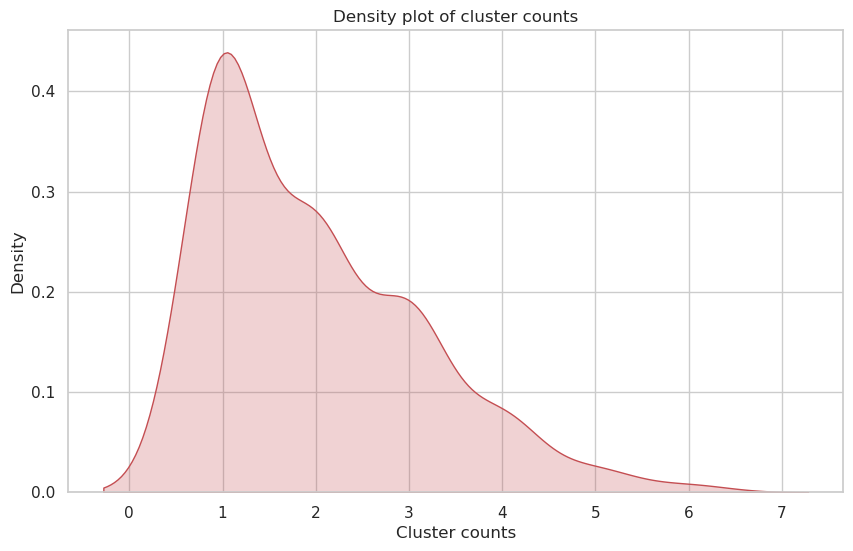

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt


# Now let's plot the density plot of the counts
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create the density plot
sns.kdeplot(cluster_counts['count'], fill=True, color="r")

# Adding labels and title
plt.xlabel('Cluster counts')
plt.ylabel('Density')
plt.title('Density plot of cluster counts')

# Display the plot
plt.show()

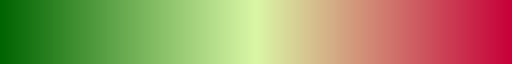

In [24]:
cmap_rg = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['#006400', '#DAF7A6', '#C70039']
)

cmap_rg

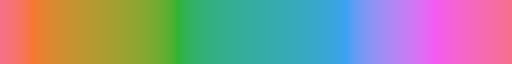

In [25]:
palette = sns.husl_palette(as_cmap=True)
palette

In [36]:
# Extract the order of LVs from result_df (make sure to adjust column names if they differ)
lv_order = result_df['LVs'].tolist()

# Reorder the distance matrix
ordered_distance_matrix = distance_matrix.loc[lv_order, lv_order]

### Heatmap of the LVs clustered 

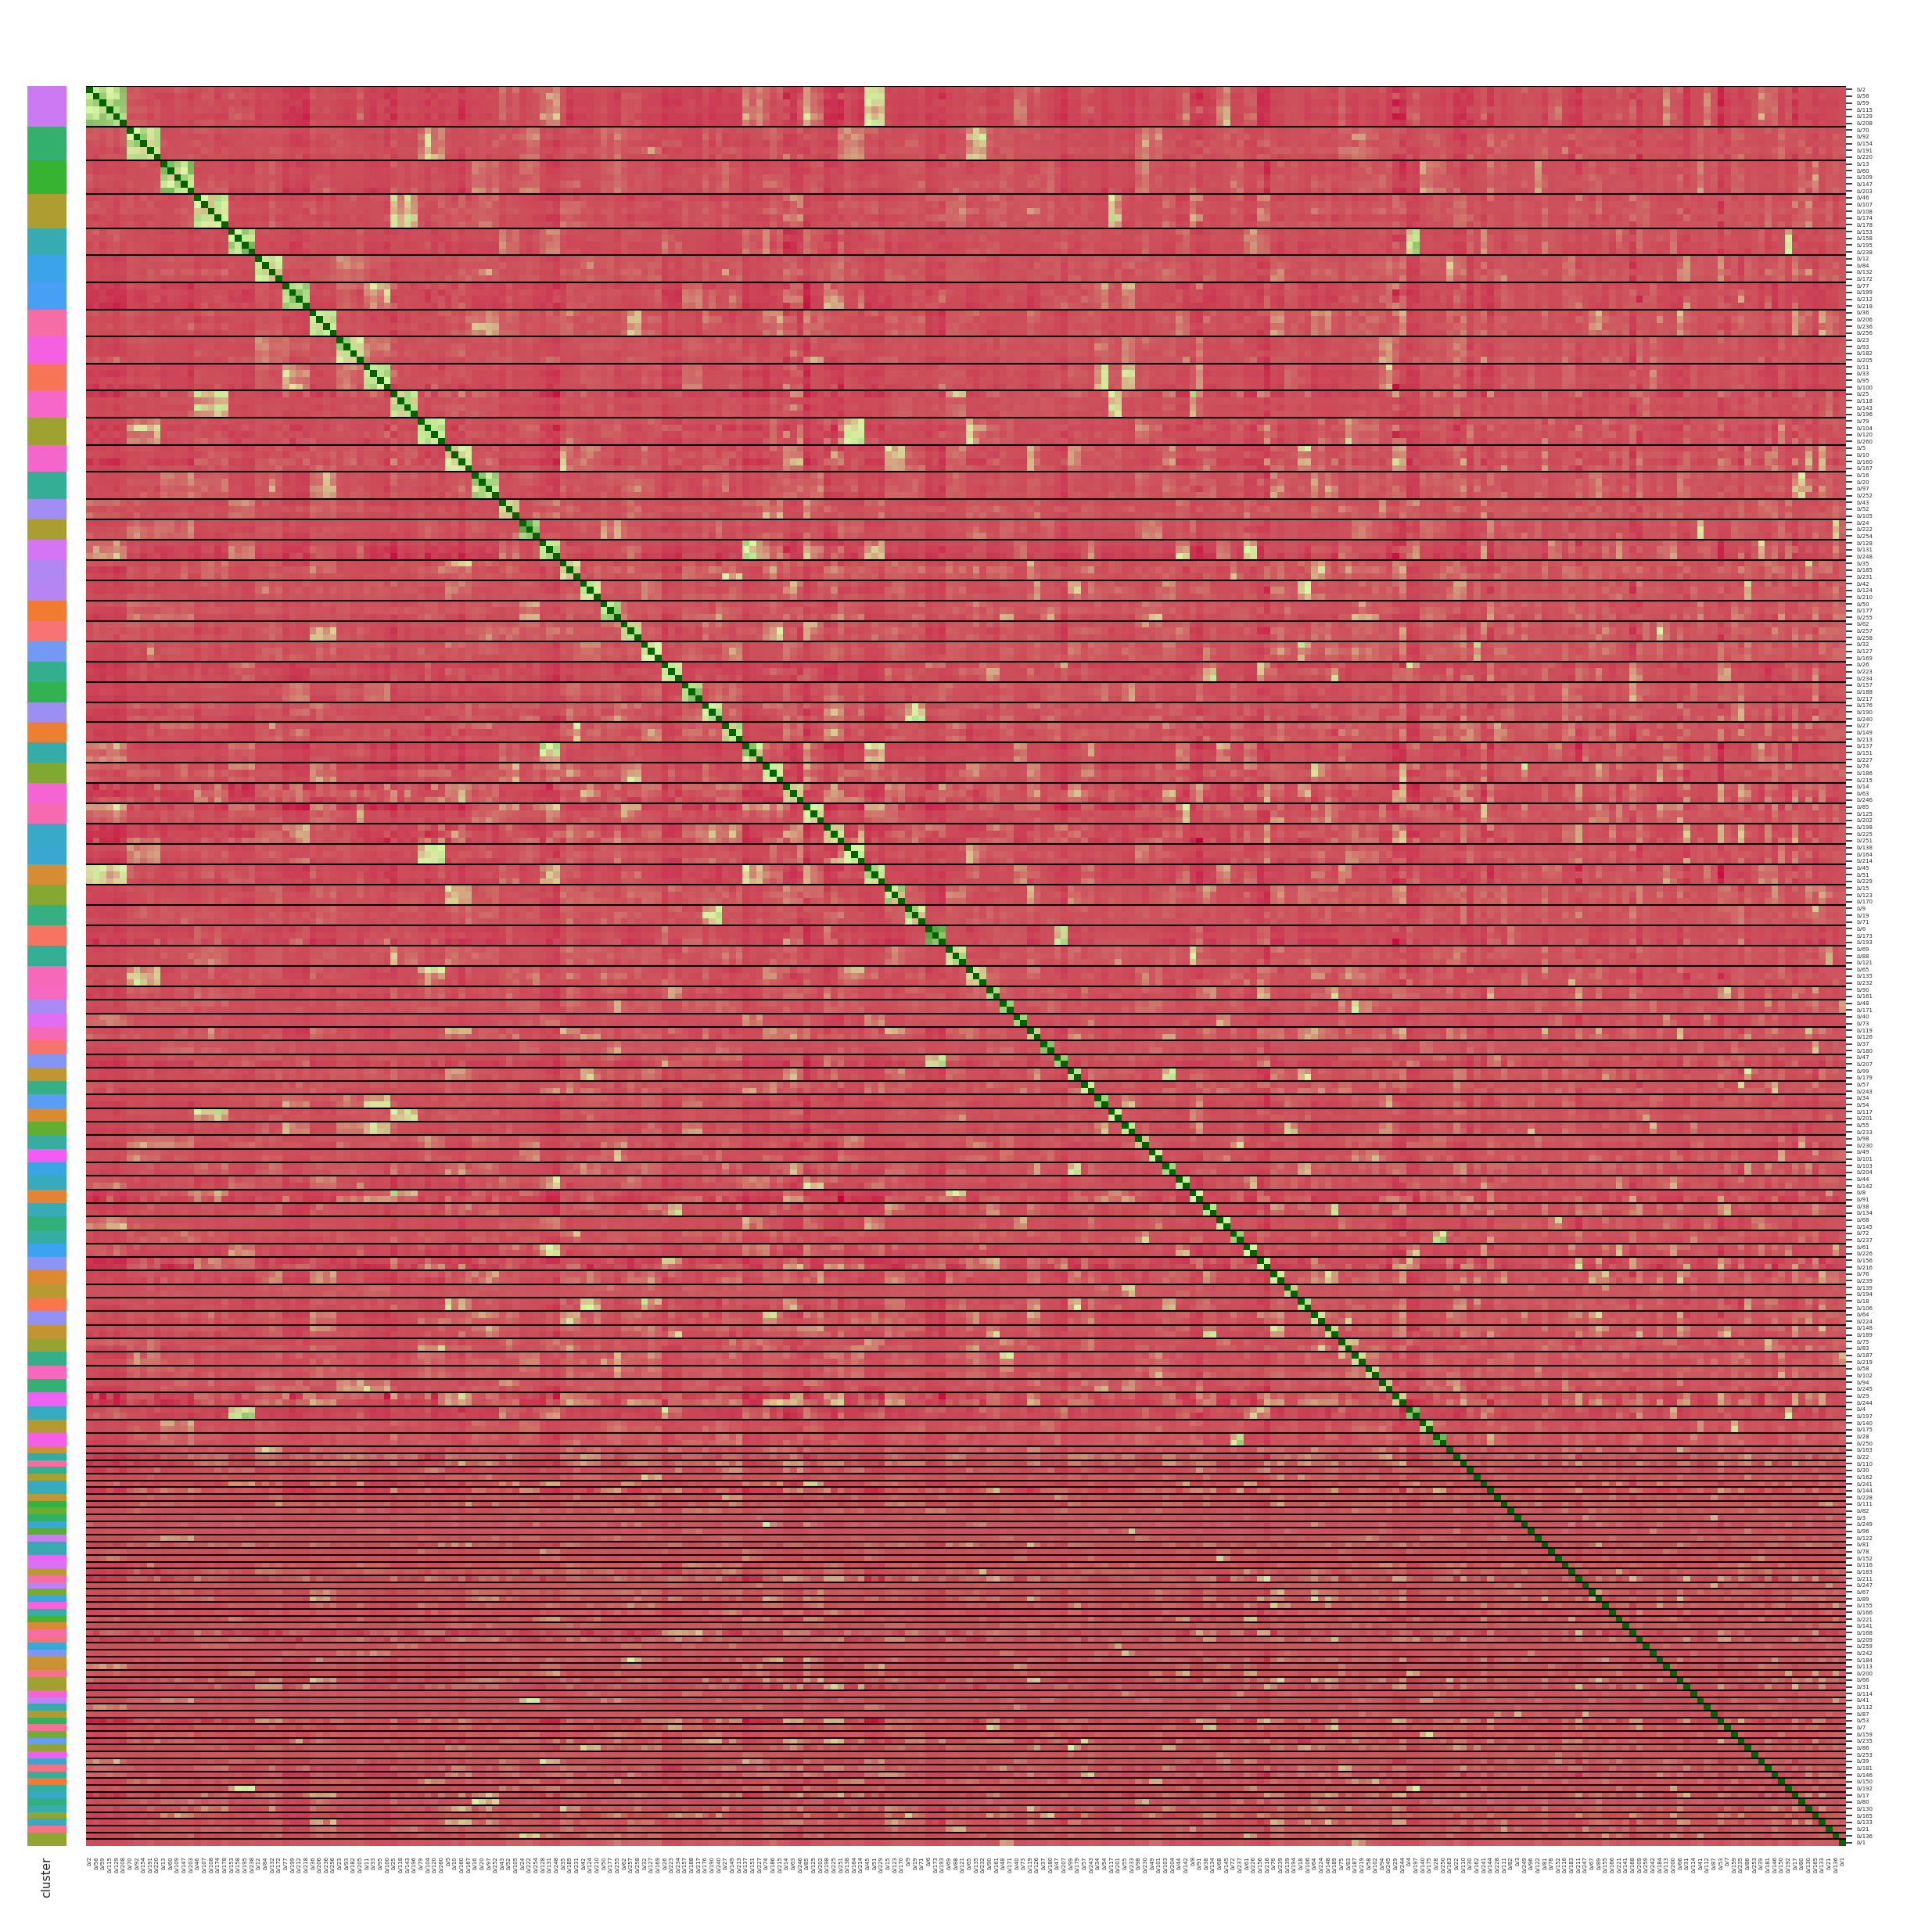

Clustermap saved as: hierarchical_clustering_lvs/clustermap_1model_high_res.png


In [41]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# ... your previous code for loading data ...

# Order the clusters_df to match the ordered distance matrix
ordered_clusters_df = clusters_df.loc[result_df['LVs']]

# Assuming that 'cluster' column contains the cluster IDs
num_unique_clusters = ordered_clusters_df['cluster'].nunique()
palette = sns.color_palette("husl", num_unique_clusters)
np.random.shuffle(palette)
color_dict = dict(zip(ordered_clusters_df['cluster'].unique(), palette))

# Map cluster labels to colors using the dictionary
# Make sure that the index matches between 'ordered_clusters_df' and 'ordered_distance_matrix'
row_colors = ordered_clusters_df['cluster'].map(color_dict)

sns.set(font_scale=1)

# Create the cluster map
g = sns.clustermap(ordered_distance_matrix,
                    row_colors=row_colors,
                    figsize=(25, 25),
                    cmap=cmap_rg,
                    cbar_pos=None,
                    row_cluster=False,
                    col_cluster=False,
                    yticklabels=True,
                    xticklabels=True)

# Adjust subplot parameters to remove white space
g.fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)

# Adjust the heatmap position if needed
heatmap_position = [0.05, 0.05, 0.9, 0.9] # Update these values as needed
g.ax_heatmap.set_position(heatmap_position)

# If row colors are present, adjust their position to align with the heatmap
if hasattr(g, 'ax_row_colors'):
    row_colors_position = [0.02, 0.05, 0.02, 0.9] # Left, bottom, width, height
    g.ax_row_colors.set_position(row_colors_position)

# Rotate the labels for better readability
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

# Adjust font size for the labels
g.ax_heatmap.tick_params(axis='x', labelsize=5)
g.ax_heatmap.tick_params(axis='y', labelsize=5)

# Calculate the indices where clusters change
diff = ordered_clusters_df['cluster'] != ordered_clusters_df['cluster'].shift(1)
change_points = diff[diff].index.tolist()

# Find positions of change points in the DataFrame's index
change_positions = [ordered_clusters_df.index.get_loc(cp) for cp in change_points if cp in ordered_clusters_df.index]

# Draw horizontal lines at cluster change points
for cp in change_positions:
    g.ax_heatmap.axhline(cp, color='black')

# Show the plot
plt.show()

# Save the figure
# Create the directory if it does not exist

directory_path = 'hierarchical_clustering_lvs'

if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Define the full path for the output file
output_filename = os.path.join(directory_path, 'clustermap_1model_high_res.png')
g.savefig(output_filename, dpi=300)

# Output the path to the saved file
print(f"Clustermap saved as: {output_filename}")

## Clustering LVs across different models

Cluster the LVs across the different models and visalize in heatmap

In [44]:
# Load models
# Define the directory containing the files
directory = here("output/gtex")

# Initialize an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

files = os.listdir(directory)
# Filter for files that start with 'plier_' and do not end with '.rds'
filtered_files = [file for file in files if file.startswith('plier_') and not file.endswith('.rds')]
item_to_remove = 'plier_result_k1_frac0.7_chr21'
filtered_files.remove(item_to_remove)
df_models=pd.DataFrame(filtered_files, columns=['file_name'])
df_models['model']=[f'M{i+1}' for i in range(len(df_models))]
df_models.head()

,file_name,model
0,plier_result_k1_frac0.7,M1
1,plier_result_k0.75_frac1,M2
2,plier_result_k2_frac0.25,M3
3,plier_result_k2_frac0.7,M4
4,plier_result_k0.75_frac0.7,M5


In [46]:
# Prepare an empty list to collect DataFrames
dfs = []

# Loop through each file, load it, rename columns, and collect it
for _, row in df_models.iterrows():
    file_path = os.path.join(directory, row['file_name'], 'Z.pkl')
    if os.path.exists(file_path):
        # Load the DataFrame from a pickle file
        df = pd.read_pickle(file_path)
        
        # Rename the columns based on the model
        df.columns = [f'{row["model"]}_LV{i+1}' for i in range(len(df.columns))]
        
        # Append the modified DataFrame to the list
        dfs.append(df)
    else:
        print(f"File not found: {file_path}")

# Concatenate all DataFrames horizontally (axis=1)
all_models_df = pd.concat(dfs, axis=1)

In [47]:
all_models_df.head()

,M1_LV1,M1_LV2,M1_LV3,M1_LV4,M1_LV5,M1_LV6,M1_LV7,M1_LV8,M1_LV9,M1_LV10,...,M32_LV251,M32_LV252,M32_LV253,M32_LV254,M32_LV255,M32_LV256,M32_LV257,M32_LV258,M32_LV259,M32_LV260
GAS6,0.000000,0.000000,0.509602,0.023033,0.0,0.047741,0.0,0.000000,0.437047,0.132950,...,0.080493,0.000000,0.003954,0.000000,0.000000,0.000000,0.000000,0.0,0.051702,0.027432
MMP14,0.000000,0.000000,0.000000,0.080798,0.0,0.000000,0.0,0.000000,0.628765,0.000000,...,0.375933,0.000000,0.000000,0.045701,0.000000,0.000000,0.000000,0.0,0.096342,0.173639
MARCKSL1,0.029505,0.000000,0.005778,0.000000,0.0,0.059613,0.0,0.000000,0.004136,0.000000,...,0.000000,0.000000,0.000000,0.109432,0.011131,0.000000,0.000000,0.0,0.000000,0.000000
SPARC,0.000000,0.000000,0.000000,0.039191,0.0,0.000000,0.0,0.040460,0.277030,0.389369,...,0.000000,0.598886,0.008699,0.000000,0.000000,0.072928,0.081403,0.0,0.165531,0.000000
CTSD,0.000000,0.154202,0.688261,0.087143,0.0,0.008311,0.0,0.167463,1.852126,0.139846,...,0.158931,0.000000,0.019957,0.018502,0.207515,0.000000,0.000000,0.0,0.000000,0.191365


Use the [Clustermatch Correlation Coefficient (CCC)](https://github.com/greenelab/ccc) to calculate correlation across latent variables (LVs), as it is much more efficient than other approaches.

In [ ]:
# Define the directory path and the full path for the output file
directory_path = 'hierarchical_clustering_lvs'
output_filename = os.path.join(directory_path, 'ccc_corrs.pkl')

# Check if the output file already exists
if os.path.exists(output_filename):
    # Load the DataFrame from the pickle file
    ccc_corrs = pd.read_pickle(output_filename)
else:
    lv_ids = final_df.columns.tolist()
    n = final_df.shape[0]

    # For each LV, select the top 1% of the genes
    data_ranked = final_df.rank().apply(lambda x: x > int(n*0.99))

    # Compute CCC between each pair of LVs
    ccc_corrs = ccc(data_ranked, n_jobs=10)

    # Convert the condensed correlation matrix to a square form and fix diagonal
    ccc_corrs = squareform(ccc_corrs)
    np.fill_diagonal(ccc_corrs, 1.0)
    ccc_corrs = pd.DataFrame(
        ccc_corrs,
        index=lv_ids,
        columns=lv_ids,
    )

    # Check if the directory exists, if not, create it
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory created: {directory_path}")

    # Save the DataFrame to a pickle file
    ccc_corrs.to_pickle(output_filename)

ccc_corrs.head()

In [ ]:
distance_matrix = 1 - ccc_corrs
clustering = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage='complete', distance_threshold=0.75)
clusters = clustering.fit_predict(distance_matrix)

distance_matrix.head()

In [ ]:
clusters_df = pd.DataFrame(clusters, columns=['cluster'])
clusters_df.index = distance_matrix.index
clusters_df['cluster'] = clusters_df['cluster'].apply(lambda x: 'CL' + str(x))
clusters_df.head()

In [ ]:
new_clusters_df = clusters_df.reset_index().rename(columns={'index': 'LVs'})

cluster_counts = clusters_df['cluster'].value_counts()
cluster_counts.columns = ['cluster', 'counts']
cluster_counts=pd.DataFrame(cluster_counts)
# Left join operation in pandas, similar to dplyr's left_join
result_df = new_clusters_df.merge(cluster_counts, on='cluster', how='left')
result_df=result_df.sort_values(by='count', ascending=False)
result_df.head(n=20)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Now let's plot the density plot of the counts
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create the density plot
sns.kdeplot(cluster_counts['count'], fill=True, color="r")

# Adding labels and title
plt.xlabel('Cluster counts')
plt.ylabel('Density')
plt.title('Density plot of cluster counts')

# Display the plot
plt.show()

In [ ]:
lv_order = result_df['LVs'].tolist()

# Reorder the rows and columns of the distance matrix
# Ensure all LVs in lv_order are actually in the distance_matrix columns
lv_order = [lv for lv in lv_order if lv in distance_matrix.columns]

# Reindex both rows and columns using the new order
ordered_distance_matrix = distance_matrix.reindex(index=lv_order, columns=lv_order)

In [ ]:
type(ordered_distance_matrix)

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# ... your previous code for loading data ...

# Order the clusters_df to match the ordered distance matrix
ordered_clusters_df = clusters_df.loc[result_df['LVs']]
# Assuming that 'cluster' column contains the cluster IDs
num_unique_clusters = ordered_clusters_df['cluster'].nunique()
palette = sns.color_palette("husl", num_unique_clusters)
np.random.shuffle(palette)
color_dict = dict(zip(ordered_clusters_df['cluster'].unique(), palette))

# Map cluster labels to colors using the dictionary
# Make sure that the index matches between 'ordered_clusters_df' and 'ordered_distance_matrix'
row_colors = ordered_clusters_df['cluster'].map(color_dict)

sns.set(font_scale=1)

# Create the cluster map
g = sns.clustermap(ordered_distance_matrix,
                    row_colors=row_colors,
                    figsize=(25, 25),
                    cmap=cmap_rg,
                    cbar_pos=None,
                    row_cluster=False,
                    col_cluster=False,
                    yticklabels=True,
                    xticklabels=True)

# Adjust subplot parameters to remove white space
g.fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)

# Adjust the heatmap position if needed
heatmap_position = [0.05, 0.05, 0.9, 0.9] # Update these values as needed
g.ax_heatmap.set_position(heatmap_position)

# If row colors are present, adjust their position to align with the heatmap
if hasattr(g, 'ax_row_colors'):
    row_colors_position = [0.02, 0.05, 0.02, 0.9] # Left, bottom, width, height
    g.ax_row_colors.set_position(row_colors_position)

# Rotate the labels for better readability
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

# Adjust font size for the labels
g.ax_heatmap.tick_params(axis='x', labelsize=5)
g.ax_heatmap.tick_params(axis='y', labelsize=5)

# Calculate the indices where clusters change
diff = ordered_clusters_df['cluster'] != ordered_clusters_df['cluster'].shift(1)
change_points = diff[diff].index.tolist()

# Find positions of change points in the DataFrame's index
change_positions = [ordered_clusters_df.index.get_loc(cp) for cp in change_points if cp in ordered_clusters_df.index]

# Draw horizontal lines at cluster change points
for cp in change_positions:
    g.ax_heatmap.axhline(cp, color='black')

# Show the plot
plt.show()

# Save the figure
output_filename = 'clustermap_high_res_all.png'
g.savefig(output_filename, dpi=300)

# Output the path to the saved file
print(f"Clustermap saved as: {output_filename}")

NameError: name 'clusters_df' is not defined

In [ ]:
def hierarchical_clustering(correlation_matrix, distance_threshold):
    # Compute the distance matrix from the correlation matrix
    distance_matrix = 1 - correlation_matrix

    # Perform Agglomerative Clustering
    clustering = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage='complete', distance_threshold=distance_threshold)
    clusters = clustering.fit_predict(distance_matrix)

    # Create a DataFrame to store the clusters
    clusters_df = pd.DataFrame(clusters, columns=['cluster'])
    clusters_df.index = distance_matrix.index
    clusters_df['cluster'] = clusters_df['cluster'].apply(lambda x: 'CL' + str(x))

    # Reset index and rename columns
    new_clusters_df = clusters_df.reset_index().rename(columns={'index': 'LVs'})

    # Count the number of LVs in each cluster
    cluster_counts = clusters_df['cluster'].value_counts().reset_index()
    cluster_counts.columns = ['cluster', 'counts']

    # Merge cluster counts with the cluster DataFrame
    result_df = new_clusters_df.merge(cluster_counts, on='cluster', how='left')
    result_df = result_df.sort_values(by=['counts', 'cluster'], ascending=[False, False])

    # Get the order of LVs based on cluster counts
    lv_order = result_df['LVs'].tolist()
    lv_order = [lv for lv in lv_order if lv in distance_matrix.columns]

    # Reorder the distance matrix based on the new LV order
    ordered_distance_matrix = distance_matrix.reindex(index=lv_order, columns=lv_order)

    return ordered_distance_matrix, clusters_df, result_df

def visualize_clusters(distance_matrix, clusters_df, result_df, size_heatmap_n=None, font_scale=1, label_font_size=10):
    cmap_rg = LinearSegmentedColormap.from_list(
        name='test',
        colors=['#006400', '#DAF7A6', '#C70039']
    )

    # Order the clusters_df to match the ordered distance matrix
    ordered_clusters_df = clusters_df.loc[result_df['LVs']]

    # Assuming that 'cluster' column contains the cluster IDs
    num_unique_clusters = ordered_clusters_df['cluster'].nunique()
    palette = sns.color_palette("husl", num_unique_clusters)
    np.random.shuffle(palette)
    color_dict = dict(zip(ordered_clusters_df['cluster'].unique(), palette))

    # Map cluster labels to colors using the dictionary
    row_colors = ordered_clusters_df['cluster'].map(color_dict)

    sns.set(font_scale=font_scale)

    # Subset the distance matrix and row_colors if size_heatmap_n is specified
    if size_heatmap_n is not None:
        distance_matrix = distance_matrix.iloc[:size_heatmap_n, :size_heatmap_n]
        row_colors = row_colors.iloc[:size_heatmap_n]

    # Create the cluster map
    g = sns.clustermap(distance_matrix,
                       row_colors=row_colors,
                       figsize=(25, 25),
                       cmap=cmap_rg,
                       cbar_pos=None,
                       row_cluster=False,
                       col_cluster=False,
                       yticklabels=True,
                       xticklabels=True)

    # Adjust subplot parameters to remove white space
    g.fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)

    # Adjust the heatmap position if needed
    heatmap_position = [0.05, 0.05, 0.9, 0.9]
    g.ax_heatmap.set_position(heatmap_position)

    # If row colors are present, adjust their position to align with the heatmap
    if hasattr(g, 'ax_row_colors'):
        row_colors_position = [0.02, 0.05, 0.02, 0.9]
        g.ax_row_colors.set_position(row_colors_position)

    # Rotate the labels for better readability
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, fontsize=label_font_size)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=label_font_size)

    # Show the plot
    plt.show()

